In [1]:
import numpy as np
import edward as ed
import pandas as pd
import tensorflow as tf
from edward.models import Normal, Multinomial, Exponential, InverseGamma
from edward.models import Bernoulli, Normal, Empirical, PointMass, Laplace
from gneiss.cluster import rank_linkage
from gneiss.balances import balance_basis
from gneiss.composition import ilr_transform
from gneiss.util import match, match_tips

from skbio.stats.composition import clr, centralize
from scipy.stats import norm, poisson
from scipy.stats import invwishart
from numpy.random import multivariate_normal, multinomial

from skbio.stats.composition import clr, ilr_inv, _gram_schmidt_basis, clr_inv
from biom import load_table
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
map_file = '../data/88soils/mapping_files/2583_mapping_file.txt'
biom_file = '../data/88soils/processed_data/238_otu_table.biom'
metadata = pd.read_table(map_file, index_col=0)
table = load_table(biom_file)

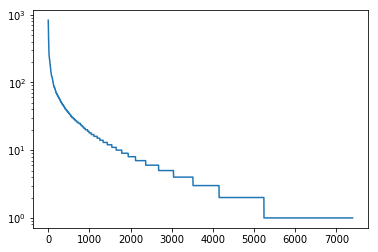

In [3]:
x = np.arange(table.shape[0])[::-1]
plt.plot(x, np.sort(table.sum(axis='observation')))
plt.yscale('log')

In [4]:
filter_fn = lambda val, id_, md: np.sum(val) > 10 # remove features with less than 10 counts
filtered_table = table.filter(filter_fn, axis='observation', inplace=False)

In [5]:
counts = pd.DataFrame(
    np.array(filtered_table.matrix_data.todense()).T,
    index=filtered_table.ids(axis='sample'),
    columns=filtered_table.ids(axis='observation'))         

In [6]:
counts = counts.loc[counts.sum(axis=1) > 10]
counts, metadata = match(counts, metadata)
metadata = metadata.sort_values(by='ph')
counts = counts.reindex(index=metadata.index)

In [7]:
from gneiss.cluster import gradient_linkage
tree = gradient_linkage(counts, metadata.ph)
counts, tree = match_tips(counts, tree)
basis, _ = balance_basis(tree)
psi_ = clr(basis)
#psi_ = _gram_schmidt_basis(counts.shape[1])

Tensorflow setup

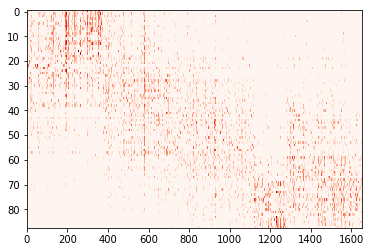

In [8]:
plt.imshow(np.log(counts+1), aspect='auto', cmap='Reds')

In [9]:
psi = tf.convert_to_tensor(psi_, dtype=tf.float32)
g = metadata.ph.values
y_data = counts.values
N, D = counts.shape
p = 2 # number of covariates
r = 2 # rank of covariance matrix
n = tf.convert_to_tensor(counts.sum(axis=1).values, dtype=tf.float32)
G_data = np.vstack((np.ones(len(g)), g)).T

In [10]:
# hack to get multinomial working
def _sample_n(self, n=1, seed=None):
    # define Python function which returns samples as a Numpy array
    def np_sample(p, n):
        return multinomial.rvs(p=p, n=n, random_state=seed).astype(np.float32)

    # wrap python function as tensorflow op
    val = tf.py_func(np_sample, [self.probs, n], [tf.float32])[0]
    # set shape from unknown shape
    batch_event_shape = self.batch_shape.concatenate(self.event_shape)
    shape = tf.concat(
        [tf.expand_dims(n, 0), tf.convert_to_tensor(batch_event_shape)], 0)
    val = tf.reshape(val, shape)
    return val
Multinomial._sample_n = _sample_n

In [11]:
import tensorflow.contrib.distributions as ds

# dummy variable for gradient
G = tf.placeholder(tf.float32, [N, p])

B = Normal(loc=tf.zeros([p, D-1]), 
           scale=tf.ones([p, D-1]))

L = Normal(loc=tf.zeros([r, D-1]), 
           scale=tf.ones([r, D-1]))
z = Normal(loc=tf.zeros([N, r]), 
           scale=tf.ones([N, r]))

# Cholesky trick to get multivariate normal
v = tf.matmul(G, B) + tf.matmul(z, L)

eta = tf.nn.softmax(tf.matmul(v, psi))
Y = Multinomial(total_count=n, probs=eta)

In [12]:
T = 100000  # the number of mixin samples from MCMC sampling

qB = PointMass(params=tf.Variable(tf.random_normal([p, D-1])))
qz = Empirical(params=tf.Variable(tf.random_normal([T, N, p])))
qL = PointMass(params=tf.Variable(tf.random_normal([p, D-1])))

# Imputation
inference_z = ed.SGLD(
    {z: qz}, 
    data={G: G_data, Y: y_data, B: qB, L: qL}
)

# Maximization
inference_BL = ed.MAP(
    {B: qB, L: qL}, 
    data={G: G_data, Y: y_data, z: qz}
)

inference_z.initialize(step_size=1e-10)
inference_BL.initialize(n_iter=5000)

sess = ed.get_session()
tf.global_variables_initializer().run()
for i in range(inference_BL.n_iter):
    inference_z.update()  # e-step
    # will need to compute the expectation of z
    
    info_dict = inference_BL.update() # m-step
    inference_BL.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ Elapsed: 222s | Loss: 146336.672


In [13]:
sess = ed.get_session()
sess.run(qB.mean())[:, :3]

array([[-65.52934265, -49.99834442,   1.25162435],
       [ 10.95292091,   8.56457329,  -0.13677487]], dtype=float32)

In [14]:
B_est = sess.run(qB.mean())

In [15]:
basis = clr_inv(psi_)
ptable = ilr_inv(G_data @ B_est, basis)

In [16]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

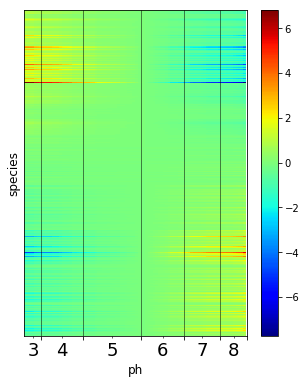

In [17]:
# jet

ticks = metadata.ph.apply(int).value_counts().sort_index().cumsum()
midpoints = ticks - (ticks - np.array([0] + list(ticks.values[:-1]))) / 2.0

fig, ax = plt.subplots(figsize=(5, 6))
p = ax.imshow(clr(centralize(ptable)).T, 
           norm=MidpointNormalize(midpoint=0.),
           aspect='auto', cmap='jet')
fig.colorbar(p)
ax.set_yticks([])
ax.set_xticks(ticks.values, minor=False)
ax.set_xticks(midpoints, minor=True)
ax.set_xticklabels(ticks.index, fontsize=18, minor=True)
ax.set_xticklabels([], fontsize=18, minor=False)
ax.grid(which='major', color='k', linestyle='-', linewidth=0.5)
ax.set_xlabel('ph', fontsize=12)
ax.set_ylabel('species', fontsize=12)

fig.savefig('../../results/clr_ph_heatmap.png')

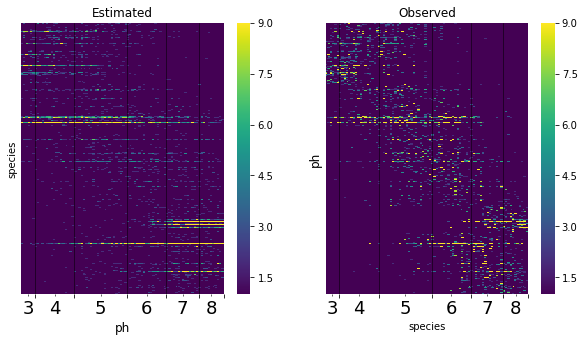

In [18]:
# jet
ticks = metadata.ph.apply(int).value_counts().sort_index().cumsum()
midpoints = ticks - (ticks - np.array([0] + list(ticks.values[:-1]))) / 2.0

fig, (ax_est, ax_obs) = plt.subplots(1, 2, figsize=(10, 5))

etable = ptable.copy()
n_ = counts.sum(axis=1).values
for i in range(etable.shape[0]):
    etable[i] = np.random.multinomial(int(n_[i]), ptable[i].ravel())
#p = ax_obs.imshow(np.log(counts+1), aspect='auto', cmap='Reds')
#fig.colorbar(p)

#p = ax_est.imshow(np.log(etable+1), 
#                  aspect='auto', cmap='Reds')
sns.heatmap(counts.T, ax=ax_obs, cmap='viridis', vmin=1, vmax=9)
sns.heatmap(etable.T, ax=ax_est, cmap='viridis', vmin=1, vmax=9)

ax_obs.set_yticks([])
ax_obs.set_xticks(ticks.values, minor=False)
ax_obs.set_xticks(midpoints, minor=True)
ax_obs.set_xticklabels(ticks.index, fontsize=18, minor=True)
ax_obs.set_xticklabels([], fontsize=18, minor=False)
ax_obs.grid(which='major', color='k', linestyle='-', linewidth=0.5)
ax_obs.set_xlabel('species')
ax_obs.set_ylabel('ph', fontsize=12)
ax_obs.set_title('Observed')

ax_est.set_yticks([])
ax_est.set_xticks(ticks.values, minor=False)
ax_est.set_xticks(midpoints, minor=True)
ax_est.set_xticklabels(ticks.index, fontsize=18, minor=True)
ax_est.set_xticklabels([], fontsize=18, minor=False)
ax_est.grid(which='major', color='k', linestyle='-', linewidth=0.5)
ax_est.set_xlabel('ph', fontsize=12)
ax_est.set_ylabel('species')
ax_est.set_title('Estimated')

fig.savefig('../../results/counts_ph_heatmap.png')

In [19]:
from numpy.random import multinomial
reps = 20

L = sess.run(qL.mean())
sigma = L.T @ L
y = G_data @ B_est
Ys = np.vstack([multivariate_normal(y[i], sigma) 
                for i in range(y.shape[0])])
Yp = ilr_inv(Ys, basis)
n_ = counts.sum(axis=1).values    
Yc = np.vstack([multinomial(n_[i], Yp[i, :]) 
                for i in range(y.shape[0])])
err = np.ravel((Yc - counts.values))

/Users/mortonjt/miniconda3/envs/edward/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  


(-10, 10)

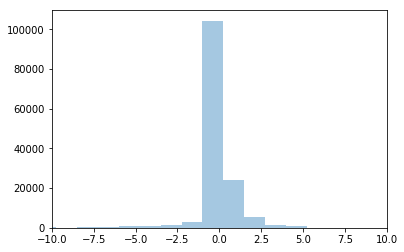

In [20]:
import seaborn as sns
sns.distplot(err.ravel(), kde=False, bins=200)
plt.xlim([-10, 10])

Now let's run the standard pseudocount method

In [21]:
from gneiss.regression import ols
balances = ilr_transform(counts+1, tree)
model = ols('ph', balances, metadata)
model.fit()
est = model.predict(tree=tree).values

In [22]:
etable = est.copy()
n_ = counts.sum(axis=1).values
for i in range(etable.shape[0]):
    etable[i] = np.random.multinomial(int(n_[i]), est[i].ravel())

In [23]:
pseudo = np.ravel(counts.values-etable)
bayes = np.ravel(counts.values-Yc)
none = np.ravel(counts.values)

In [24]:
unique_pseudo, counts_pseudo = np.unique(pseudo, return_counts=True)
unique_bayes, counts_bayes = np.unique(bayes, return_counts=True)
unique_none, counts_none = np.unique(none, return_counts=True)

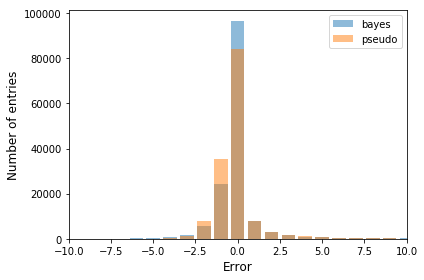

In [25]:
#plt.bar(unique_none, counts_none, alpha=0.5, label='none')
plt.bar(unique_bayes, counts_bayes, alpha=0.5, label='bayes')
plt.bar(unique_pseudo, counts_pseudo, alpha=0.5, label='pseudo')
plt.legend()
plt.xlim([-10, 10])
plt.xlabel('Error', fontsize=12)
plt.ylabel('Number of entries', fontsize=12)
plt.tight_layout()
plt.savefig('compare_mse.png')
#plt.xscale('log')

In [46]:
model.coefficients()

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y1641,y1642,y1643,y1644,y1645,y1646,y1647,y1648,y1649,y1650
Intercept,-17.979988,-15.548521,-0.484654,2.805009,-5.473191,1.551708,3.376528,1.914037,-1.108685,-2.268525,...,-0.065802,-1.356020e-16,0.384727,0.029406,-0.093032,-0.041968,-0.074541,0.184220,-0.013607,0.961371
ph,2.999660,2.330060,0.108885,-0.435023,0.841343,-0.227914,-0.490488,-0.257519,0.171293,0.403932,...,-0.011424,-2.719706e-18,-0.027718,-0.007785,0.019373,-0.006123,0.031227,-0.038293,0.000147,-0.226440


In [47]:
B_est = sess.run(qB.mean())

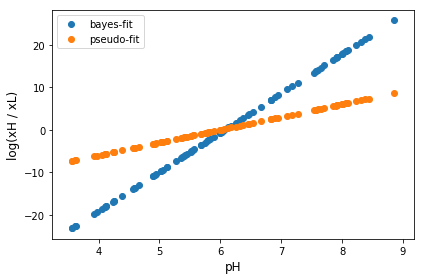

In [52]:
x = metadata.ph.values
p0 = model.coefficients().y0[0] 
p1 = model.coefficients().y0[1] 

b0 = B_est[0, 0]
b1 = B_est[1, 0]

plt.scatter(x, x * b1 + b0, label='bayes-fit')
plt.scatter(x, x * p1 + p0, label='pseudo-fit')
plt.xlabel('pH', fontsize=12)
plt.ylabel(r'log(xH / xL)', fontsize=12)
plt.tight_layout()
plt.legend()
plt.savefig('logratios.png')

In [29]:
metadata.ph

#SampleID
103.CF3    3.56
103.PE5    3.57
103.BF2    3.61
103.CF2    3.63
103.CF1    3.92
103.HF2    3.98
103.BF1    4.05
103.PE4    4.10
103.PE2    4.11
103.PE1    4.12
103.PE6    4.12
103.TL3    4.23
103.HF1    4.25
103.PE3    4.25
103.MP2    4.38
103.MP1    4.56
103.TL1    4.58
103.BB2    4.60
103.LQ3    4.67
103.CL3    4.89
103.LQ1    4.89
103.HI4    4.92
103.SN1    4.95
103.CL4    5.03
103.LQ2    5.03
103.DF3    5.05
103.BZ1    5.12
103.SP2    5.13
103.IE1    5.27
103.HJ2    5.36
           ... 
103.DF2    6.84
103.GB1    6.84
103.SR1    6.84
103.SA1    6.90
103.SR3    6.95
103.KP4    7.10
103.GB3    7.18
103.CA1    7.27
103.BP1    7.53
103.MT1    7.57
103.GB2    7.57
103.JT1    7.60
103.MD2    7.65
103.SF1    7.71
103.CM1    7.85
103.MD3    7.90
103.RT1    7.92
103.KP3    7.92
103.SB1    7.92
103.SR2    8.00
103.CR1    8.00
103.CA2    8.02
103.RT2    8.07
103.MD5    8.07
103.SA2    8.10
103.GB5    8.22
103.SV1    8.31
103.SF2    8.38
103.SV2    8.44
103.MD4    8.86
Name: ph, Leng

In [30]:
np.mean(pseudo ** 2)

6.0528147699757868

In [31]:
np.mean(bayes ** 2)

4.9501568346907332

In [32]:
# 1. MSE 
# 2. R-squared

In [33]:
unique_pseudo

array([  -7.,   -6.,   -5.,   -4.,   -3.,   -2.,   -1.,    0.,    1.,
          2.,    3.,    4.,    5.,    6.,    7.,    8.,    9.,   10.,
         11.,   12.,   13.,   14.,   15.,   16.,   17.,   18.,   19.,
         20.,   21.,   22.,   23.,   24.,   25.,   26.,   27.,   28.,
         29.,   30.,   31.,   32.,   33.,   34.,   35.,   36.,   37.,
         38.,   39.,   40.,   41.,   42.,   43.,   44.,   45.,   46.,
         47.,   48.,   50.,   51.,   52.,   53.,   54.,   55.,   57.,
         58.,   59.,   61.,   62.,   63.,   66.,   67.,   70.,   73.,
         74.,   75.,   76.,   77.,   84.,   86.,   88.,   91.,  104.,
        119.,  143.,  145.,  146.,  171.,  210.])

In [34]:
counts_pseudo

array([    1,     9,    22,   194,  1356,  7900, 35242, 83970,  7744,
        3155,  1750,  1058,   687,   490,   329,   245,   195,   133,
         111,    96,    80,    76,    68,    59,    38,    38,    28,
          34,    28,    26,    18,    20,    15,     7,     8,    14,
           5,    12,     9,     5,     7,     5,     3,     6,     4,
           5,     1,     6,     2,     9,     1,     2,     2,     2,
           1,     1,     1,     2,     4,     1,     1,     1,     3,
           1,     3,     1,     1,     2,     2,     1,     1,     1,
           1,     2,     2,     1,     1,     2,     1,     1,     1,
           1,     1,     1,     1,     1,     1])

In [35]:
unique_bayes

array([ -44.,  -34.,  -32.,  -30.,  -29.,  -26.,  -25.,  -24.,  -23.,
        -22.,  -21.,  -20.,  -19.,  -18.,  -17.,  -16.,  -15.,  -14.,
        -13.,  -12.,  -11.,  -10.,   -9.,   -8.,   -7.,   -6.,   -5.,
         -4.,   -3.,   -2.,   -1.,    0.,    1.,    2.,    3.,    4.,
          5.,    6.,    7.,    8.,    9.,   10.,   11.,   12.,   13.,
         14.,   15.,   16.,   17.,   18.,   19.,   20.,   21.,   22.,
         23.,   24.,   25.,   26.,   27.,   28.,   29.,   30.,   31.,
         32.,   33.,   34.,   35.,   36.,   37.,   38.,   39.,   40.,
         41.,   42.,   43.,   44.,   45.,   46.,   47.,   48.,   50.,
         51.,   52.,   53.,   54.,   55.,   56.,   58.,   59.,   60.,
         63.,   65.,   67.,   68.,   69.,   72.,   73.,   75.,   84.,
         85.,   99.,  120.,  124.,  130.,  134.,  206.])

In [36]:
counts_bayes

array([    1,     1,     1,     1,     2,     1,     2,     2,     2,
           6,     1,     3,     4,     7,     9,     8,     6,     8,
           9,    15,    23,    26,    45,    57,    99,   143,   303,
         603,  1608,  5521, 24251, 96661,  7753,  3076,  1631,   992,
         622,   413,   293,   202,   143,   137,   103,    66,    71,
          70,    35,    43,    32,    27,    26,    26,    24,    14,
          13,    14,    11,     4,     5,     6,    11,     6,    10,
           4,     1,     6,     3,     1,     1,     2,     1,     4,
           3,     2,     2,     1,     2,     1,     2,     1,     1,
           2,     1,     1,     1,     1,     1,     1,     2,     1,
           2,     1,     1,     2,     1,     1,     1,     2,     1,
           1,     1,     1,     1,     1,     1,     1])

In [37]:
# Validation dataset for parameter tuning?
# Hyperpriors on priors

In [38]:
idx = np.random.random(G.shape[0]) < 0.9
N = np.sum(idx)
n = tf.convert_to_tensor(y_data[idx].sum(axis=1), dtype=tf.float32)

psi = tf.convert_to_tensor(psi_, dtype=tf.float32)
g = metadata.ph.values[idx]
y_data = counts.values[idx]
D = counts.shape[1]
p = 2 # number of covariates
r = 2 # rank of covariance matrix
G_data = np.vstack((np.ones(len(g)), g)).T

# dummy variable for gradient
G = tf.placeholder(tf.float32, [N, p])

B = Normal(loc=tf.zeros([p, D-1]), 
           scale=tf.ones([p, D-1]))

L = Normal(loc=tf.zeros([r, D-1]), 
           scale=tf.ones([r, D-1]))
z = Normal(loc=tf.zeros([N, r]), 
           scale=tf.ones([N, r]))

# Cholesky trick to get multivariate normal
v = tf.matmul(G, B) + tf.matmul(z, L)

eta = tf.nn.softmax(tf.matmul(v, psi))
Y = Multinomial(total_count=n, probs=eta)

In [39]:
T = 100000  # the number of mixin samples from MCMC sampling

qB = PointMass(params=tf.Variable(tf.random_normal([p, D-1])))
qz = Empirical(params=tf.Variable(tf.random_normal([T, N, p])))
qL = PointMass(params=tf.Variable(tf.random_normal([p, D-1])))

# Imputation
inference_z = ed.SGLD(
    {z: qz}, 
    data={G: G_data, Y: y_data, B: qB, L: qL}
)

# Maximization
inference_BL = ed.MAP(
    {B: qB, L: qL}, 
    data={G: G_data, Y: y_data, z: qz}
)

inference_z.initialize(step_size=1e-10)
inference_BL.initialize(n_iter=5000)

sess = ed.get_session()
tf.global_variables_initializer().run()
for i in range(inference_BL.n_iter):
    inference_z.update()  # e-step
    # will need to compute the expectation of z
    
    info_dict = inference_BL.update() # m-step
    inference_BL.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ Elapsed: 185s | Loss: 122115.766


In [40]:
from numpy.random import multinomial
reps = 20
g = metadata.ph.values[~idx]
G_data = np.vstack((np.ones(len(g)), g)).T

L = sess.run(qL.mean())
B_est = sess.run(qB.mean())
sigma = L.T @ L
y = G_data @ B_est
Ys = np.vstack([multivariate_normal(y[i], sigma) 
                for i in range(y.shape[0])])
Yp = ilr_inv(Ys, basis)
n_ = counts.sum(axis=1).values    
Yc = np.vstack([multinomial(n_[i], Yp[i, :]) 
                for i in range(y.shape[0])])
err = np.ravel((Yc - counts.values[~idx]))

/Users/mortonjt/miniconda3/envs/edward/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()


In [41]:
np.mean(err**2)

4.8460956416464889

In [42]:
from gneiss.regression import ols
balances = ilr_transform(counts.iloc[~idx]+1, tree)
model = ols('ph', balances, metadata)
model.fit()
B_est = model.coefficients().values
est = ilr_inv(G_data @ B_est , basis)
etable = est.copy()
n_ = counts.sum(axis=1).values[~idx]
for i in range(etable.shape[0]):
    etable[i] = np.random.multinomial(int(n_[i]), est[i].ravel())

In [43]:
perr = np.ravel((etable - counts.values[~idx]))

In [44]:
np.mean(perr ** 2)

5.3554782082324452